In [1]:
import glob
import sys

import numpy as np
import pandas as pd
from xgboost import XGBClassifier, XGBRFClassifier

sys.path.append("../../../")

from helpers.experiment import experiment
from helpers.split import tag_label_feature_split

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index




Commencing Experiment: XGBClassifier_dataset_00_all

Training accuracy: train_accuracy = 0.829333

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.1791    0.3039      374  0.4194
  genre_classical     0.9060  0.9360    0.9208     4221  0.8944
    genre_country     1.0000  0.4312    0.6026      327  0.6530
      genre_disco     0.9405  0.6021    0.7342      289  0.7494
     genre_hiphop     0.8514  0.9030    0.8765     1701  0.8628
       genre_jazz     0.8743  0.7228    0.7914     1241  0.7807
      genre_metal     0.9653  0.7113    0.8190      665  0.8230
        genre_pop     0.7169  0.8711    0.7865     4274  0.7121
     genre_reggae     0.9283  0.7881    0.8524      788  0.8490
       genre_rock     0.8212  0.8069    

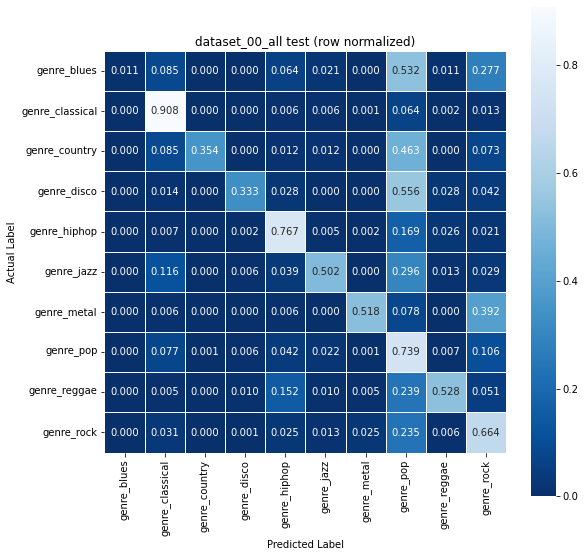



Commencing Experiment: XGBClassifier_dataset_01_mean

Training accuracy: train_accuracy = 0.593970

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.7753  0.8673    0.8187     4221  0.7569
    genre_country     0.9688  0.0948    0.1727      327  0.3002
      genre_disco     1.0000  0.0069    0.0137      289  0.0825
     genre_hiphop     0.5066  0.4268    0.4633     1701  0.4114
       genre_jazz     0.5888  0.2538    0.3547     1241  0.3576
      genre_metal     0.7619  0.2887    0.4188      665  0.4574
        genre_pop     0.4683  0.7092    0.5641     4274  0.3933
     genre_reggae     0.6497  0.1294    0.2159      788  0.2771
       genre_rock     0.6000  0.6516   

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000       94  0.0000
  genre_classical     0.7498  0.8692    0.8051     1055  0.7385
    genre_country     1.0000  0.0732    0.1364       82  0.2681
      genre_disco     0.0000  0.0000    0.0000       72  0.0000
     genre_hiphop     0.4303  0.3341    0.3762      425  0.3198
       genre_jazz     0.4746  0.1801    0.2611      311  0.2606
      genre_metal     0.6531  0.1928    0.2977      166  0.3423
        genre_pop     0.4184  0.6455    0.5077     1069  0.3078
     genre_reggae     0.3333  0.0508    0.0881      197  0.1152
       genre_rock     0.5439  0.5887    0.5654      800  0.4609
                                                               
         accuracy                       0.5441     4271  0.4267
        macro avg     0.4603  0.2934    0.3038     4271        
     weighted avg     0.529

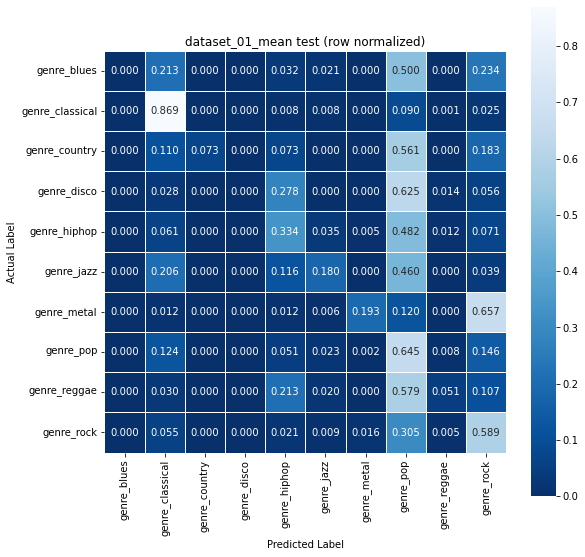



Commencing Experiment: XGBClassifier_dataset_02_mean_cov

Training accuracy: train_accuracy = 0.717389

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.0053    0.0106      374  0.0723
  genre_classical     0.8403  0.9138    0.8755     4221  0.8336
    genre_country     0.9796  0.2936    0.4518      327  0.5324
      genre_disco     0.8000  0.1246    0.2156      289  0.3121
     genre_hiphop     0.6881  0.6849    0.6865     1701  0.6519
       genre_jazz     0.8019  0.4762    0.5976     1241  0.5966
      genre_metal     0.9441  0.4827    0.6388      665  0.6669
        genre_pop     0.5972  0.7789    0.6761     4274  0.5576
     genre_reggae     0.7831  0.6003    0.6796      788  0.6726
       genre_rock     0.7015  0.744

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000       94  0.0000
  genre_classical     0.7860  0.8806    0.8306     1055  0.7730
    genre_country     0.8667  0.1585    0.2680       82  0.3666
      genre_disco     0.6667  0.0833    0.1481       72  0.2319
     genre_hiphop     0.4692  0.4306    0.4491      425  0.3915
       genre_jazz     0.6369  0.3215    0.4274      311  0.4241
      genre_metal     0.7273  0.2410    0.3620      166  0.4068
        genre_pop     0.4835  0.6576    0.5573     1069  0.3868
     genre_reggae     0.5954  0.3959    0.4756      197  0.4658
       genre_rock     0.5820  0.6388    0.6091      800  0.5146
                                                               
         accuracy                       0.6001     4271  0.5008
        macro avg     0.5814  0.3808    0.4127     4271        
     weighted avg     0.600

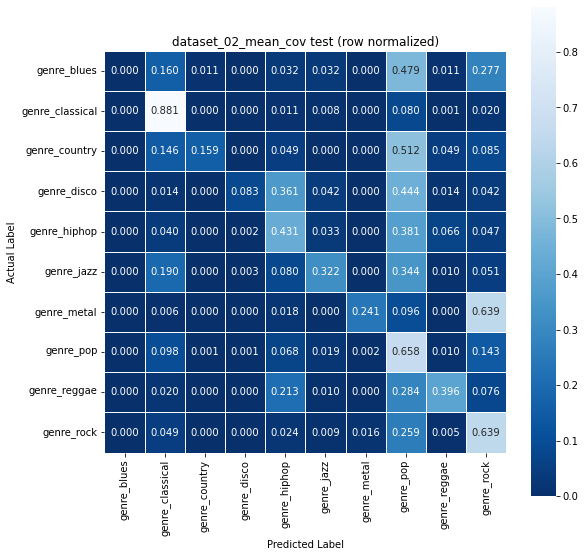



Commencing Experiment: XGBClassifier_dataset_03_mean_icov

Training accuracy: train_accuracy = 0.709660

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.0107    0.0212      374  0.1023
  genre_classical     0.8422  0.9055    0.8727     4221  0.8299
    genre_country     1.0000  0.2661    0.4203      327  0.5121
      genre_disco     0.8846  0.1592    0.2698      289  0.3718
     genre_hiphop     0.7062  0.6473    0.6755     1701  0.6420
       genre_jazz     0.7346  0.4907    0.5884     1241  0.5760
      genre_metal     0.9210  0.4556    0.6097      665  0.6390
        genre_pop     0.5781  0.7918    0.6682     4274  0.5465
     genre_reggae     0.8473  0.5774    0.6868      788  0.6881
       genre_rock     0.7019  0.72

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000       94  0.0000
  genre_classical     0.8012  0.8938    0.8450     1055  0.7925
    genre_country     1.0000  0.2195    0.3600       82  0.4650
      genre_disco     0.6000  0.0833    0.1463       72  0.2194
     genre_hiphop     0.5329  0.4188    0.4690      425  0.4217
       genre_jazz     0.5690  0.3183    0.4082      311  0.3935
      genre_metal     0.7302  0.2771    0.4017      166  0.4376
        genre_pop     0.4785  0.6773    0.5608     1069  0.3902
     genre_reggae     0.5856  0.3299    0.4221      197  0.4201
       genre_rock     0.5741  0.6250    0.5984      800  0.5017
                                                               
         accuracy                       0.6038     4271  0.5055
        macro avg     0.5871  0.3843    0.4212     4271        
     weighted avg     0.604

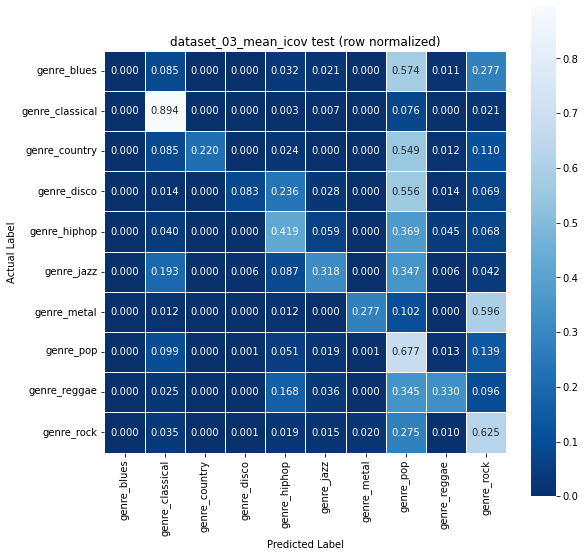



Commencing Experiment: XGBClassifier_dataset_04_mean_cov_icov

Training accuracy: train_accuracy = 0.742857

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.0267    0.0521      374  0.1618
  genre_classical     0.8581  0.9100    0.8833     4221  0.8441
    genre_country     1.0000  0.3303    0.4966      327  0.5710
      genre_disco     0.8750  0.2180    0.3490      289  0.4329
     genre_hiphop     0.7451  0.7372    0.7411     1701  0.7127
       genre_jazz     0.7976  0.5334    0.6393     1241  0.6312
      genre_metal     0.9578  0.5459    0.6954      665  0.7156
        genre_pop     0.6202  0.8095    0.7023     4274  0.5949
     genre_reggae     0.8411  0.6383    0.7258      788  0.7219
       genre_rock     0.7247  

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


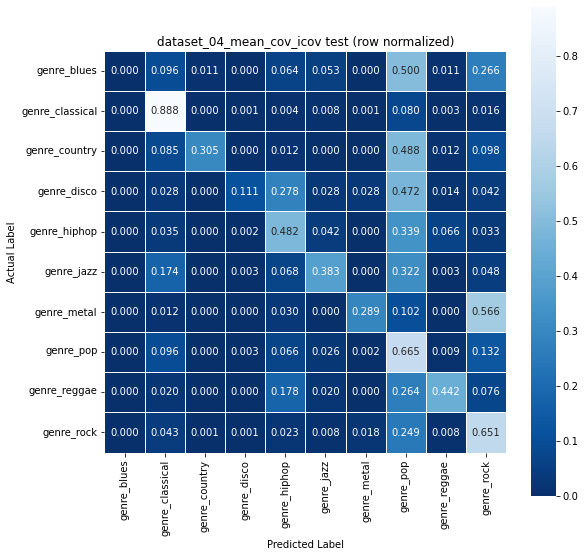



Commencing Experiment: XGBClassifier_dataset_05_pvtt

Training accuracy: train_accuracy = 0.581206

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.8320  0.8659    0.8486     4221  0.7979
    genre_country     0.8750  0.0214    0.0418      327  0.1352
      genre_disco     1.0000  0.0277    0.0539      289  0.1650
     genre_hiphop     0.4676  0.3304    0.3872     1701  0.3381
       genre_jazz     0.5565  0.2619    0.3562     1241  0.3507
      genre_metal     0.7667  0.1038    0.1828      665  0.2738
        genre_pop     0.4447  0.7342    0.5539     4274  0.3767
     genre_reggae     0.5899  0.1624    0.2547      788  0.2940
       genre_rock     0.5780  0.6359   

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

record saved
                   precision  recall  f1-score  support      mcc
                                                                
      genre_blues     0.0000  0.0000    0.0000       94   0.0000
  genre_classical     0.8107  0.8730    0.8407     1055   0.7868
    genre_country     0.0000  0.0000    0.0000       82  -0.0021
      genre_disco     0.0000  0.0000    0.0000       72   0.0000
     genre_hiphop     0.3684  0.2306    0.2836      425   0.2315
       genre_jazz     0.4621  0.2154    0.2939      311   0.2808
      genre_metal     0.4706  0.0482    0.0874      166   0.1412
        genre_pop     0.4017  0.6688    0.5019     1069   0.2954
     genre_reggae     0.5000  0.1218    0.1959      197   0.2307
       genre_rock     0.5216  0.5725    0.5459      800   0.4359
                                                                
         accuracy                       0.5364     4271   0.4177
        macro avg     0.3535  0.2730    0.2749     4271         
     weighte

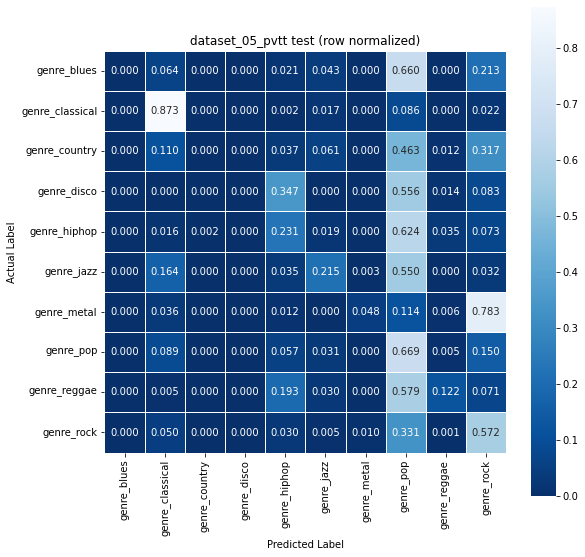



Commencing Experiment: XGBClassifier_dataset_06_pvtt_mean

Training accuracy: train_accuracy = 0.649122

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.8522  0.8879    0.8697     4221  0.8261
    genre_country     0.8276  0.1468    0.2494      327  0.3444
      genre_disco     0.7250  0.1003    0.1763      289  0.2660
     genre_hiphop     0.5825  0.5356    0.5580     1701  0.5120
       genre_jazz     0.6185  0.3932    0.4808     1241  0.4628
      genre_metal     0.8571  0.3158    0.4615      665  0.5103
        genre_pop     0.5150  0.7443    0.6087     4274  0.4600
     genre_reggae     0.6525  0.3503    0.4558      788  0.4606
       genre_rock     0.6486  0.68

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000       94  0.0000
  genre_classical     0.8189  0.8787    0.8477     1055  0.7963
    genre_country     0.8182  0.1098    0.1935       82  0.2959
      genre_disco     0.8000  0.1111    0.1951       72  0.2947
     genre_hiphop     0.5110  0.4353    0.4701      425  0.4184
       genre_jazz     0.5319  0.3215    0.4008      311  0.3791
      genre_metal     0.7111  0.1928    0.3033      166  0.3589
        genre_pop     0.4516  0.6726    0.5404     1069  0.3583
     genre_reggae     0.4557  0.1827    0.2609      197  0.2681
       genre_rock     0.5869  0.6250    0.6053      800  0.5112
                                                               
         accuracy                       0.5891     4271  0.4869
        macro avg     0.5685  0.3529    0.3817     4271        
     weighted avg     0.592

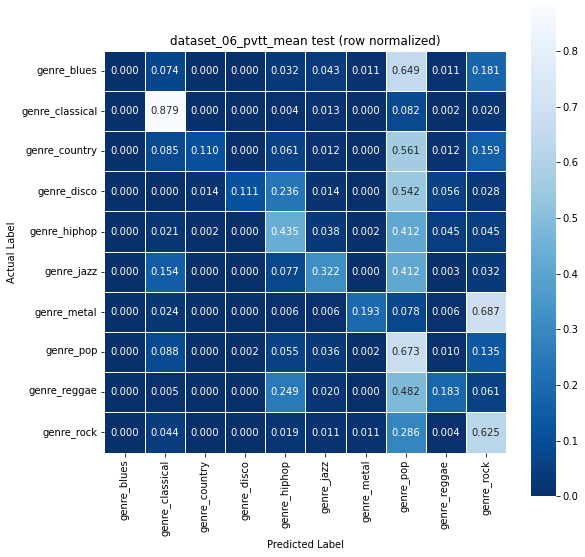



Commencing Experiment: XGBClassifier_dataset_07_pvtt_mean_cov

Training accuracy: train_accuracy = 0.730152

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.0107    0.0212      374  0.1023
  genre_classical     0.8768  0.9074    0.8918     4221  0.8557
    genre_country     0.9802  0.3028    0.4626      327  0.5409
      genre_disco     0.8088  0.1903    0.3081      289  0.3882
     genre_hiphop     0.7005  0.7178    0.7091     1701  0.6765
       genre_jazz     0.8082  0.5230    0.6350     1241  0.6294
      genre_metal     0.9582  0.4827    0.6420      665  0.6722
        genre_pop     0.6002  0.7985    0.6853     4274  0.5708
     genre_reggae     0.7794  0.6142    0.6870      788  0.6789
       genre_rock     0.7147  

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000       94  0.0000
  genre_classical     0.8350  0.8872    0.8603     1055  0.8133
    genre_country     0.8421  0.1951    0.3168       82  0.4009
      genre_disco     1.0000  0.1389    0.2439       72  0.3700
     genre_hiphop     0.5172  0.4612    0.4876      425  0.4354
       genre_jazz     0.6687  0.3441    0.4544      311  0.4525
      genre_metal     0.7586  0.2651    0.3929      166  0.4369
        genre_pop     0.4903  0.6829    0.5708     1069  0.4053
     genre_reggae     0.6233  0.4619    0.5306      197  0.5177
       genre_rock     0.5951  0.6613    0.6264      800  0.5358
                                                               
         accuracy                       0.6226     4271  0.5303
        macro avg     0.6330  0.4098    0.4484     4271        
     weighted avg     0.631

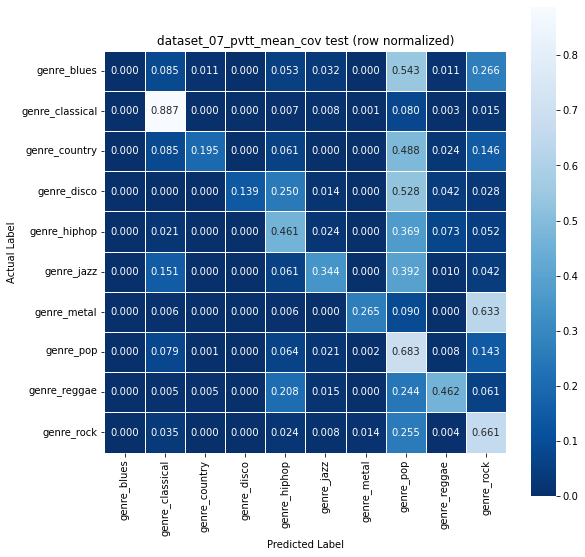



Commencing Experiment: XGBClassifier_dataset_08_pvtt_mean_icov

Training accuracy: train_accuracy = 0.727986

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.0107    0.0212      374  0.1023
  genre_classical     0.8695  0.9109    0.8897     4221  0.8528
    genre_country     0.9515  0.2997    0.4558      327  0.5299
      genre_disco     0.7500  0.2284    0.3501      289  0.4090
     genre_hiphop     0.7372  0.6778    0.7063     1701  0.6760
       genre_jazz     0.7667  0.5351    0.6303     1241  0.6180
      genre_metal     0.9271  0.4782    0.6310      665  0.6573
        genre_pop     0.5933  0.8058    0.6834     4274  0.5683
     genre_reggae     0.8272  0.6015    0.6965      788  0.6937
       genre_rock     0.7150 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000       94  0.0000
  genre_classical     0.8310  0.8948    0.8617     1055  0.8151
    genre_country     1.0000  0.2317    0.3762       82  0.4778
      genre_disco     0.6000  0.1250    0.2069       72  0.2689
     genre_hiphop     0.5572  0.4471    0.4961      425  0.4504
       genre_jazz     0.6146  0.3794    0.4692      311  0.4524
      genre_metal     0.7302  0.2771    0.4017      166  0.4376
        genre_pop     0.4812  0.6838    0.5649     1069  0.3961
     genre_reggae     0.6186  0.3706    0.4635      197  0.4601
       genre_rock     0.5864  0.6362    0.6103      800  0.5166
                                                               
         accuracy                       0.6179     4271  0.5241
        macro avg     0.6019  0.4046    0.4451     4271        
     weighted avg     0.622

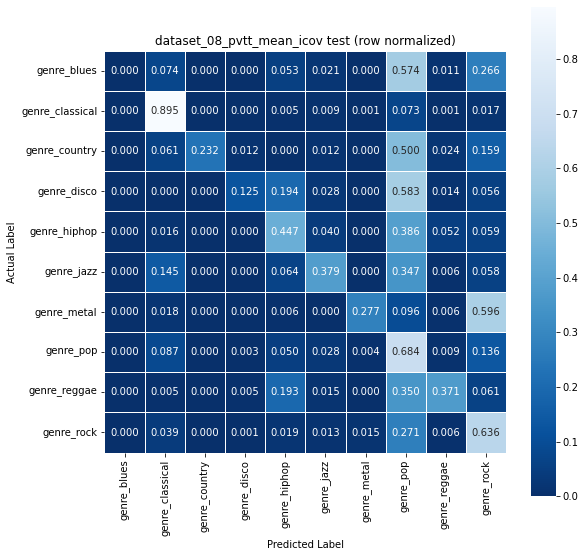



Commencing Experiment: XGBClassifier_dataset_09_pvtt_mean_cov_icov

Training accuracy: train_accuracy = 0.750995

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.0160    0.0316      374  0.1253
  genre_classical     0.8796  0.9157    0.8973     4221  0.8630
    genre_country     0.9732  0.3333    0.4966      327  0.5656
      genre_disco     0.8488  0.2526    0.3893      289  0.4589
     genre_hiphop     0.7466  0.7431    0.7448     1701  0.7167
       genre_jazz     0.7991  0.5770    0.6701     1241  0.6585
      genre_metal     0.9643  0.5278    0.6822      665  0.7059
        genre_pop     0.6279  0.8156    0.7095     4274  0.6051
     genre_reggae     0.8211  0.6523    0.7270      788  0.7205
       genre_rock     0.7

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


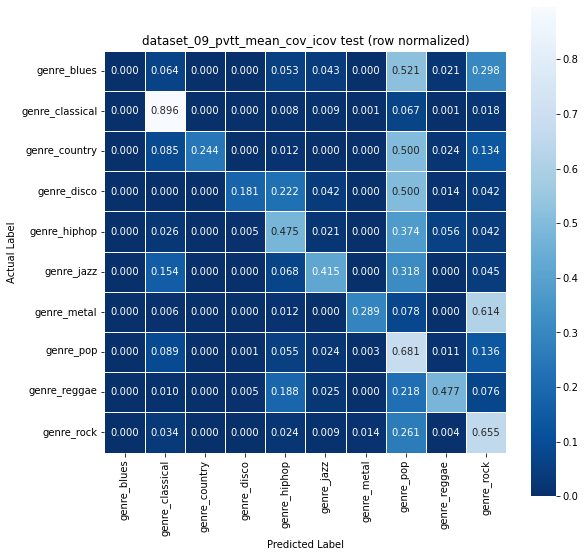



Commencing Experiment: XGBClassifier_dataset_10_melspectrograms_flattened

Training accuracy: train_accuracy = 0.830738

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.9903  0.2727    0.4277      374  0.5154
  genre_classical     0.8451  0.9420    0.8909     4221  0.8547
    genre_country     1.0000  0.3058    0.4684      327  0.5493
      genre_disco     1.0000  0.5260    0.6893      289  0.7223
     genre_hiphop     0.9622  0.8078    0.8782     1701  0.8701
       genre_jazz     0.9558  0.6962    0.8056     1241  0.8043
      genre_metal     0.9774  0.7143    0.8254      665  0.8302
        genre_pop     0.7158  0.8893    0.7932     4274  0.7220
     genre_reggae     1.0000  0.7563    0.8613      788  0.8646
       genre_rock 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


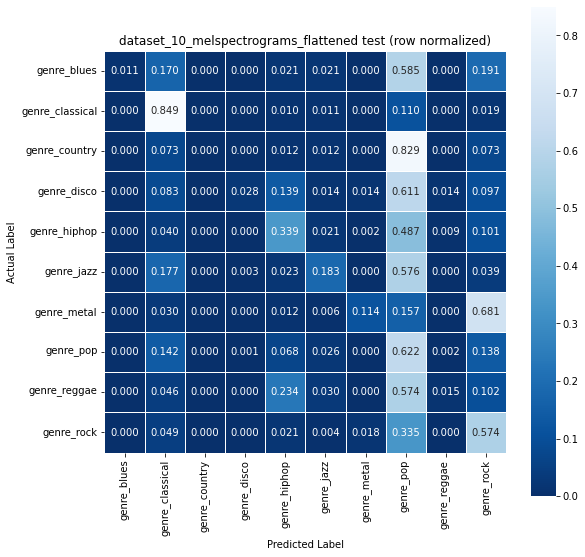

In [2]:
dataset_folder = "../../../datasets/"
datasets = sorted([name for name in glob.glob(dataset_folder + "dataset_*.pickle")])

for dataset in datasets:

    if "spectrogram" in dataset:
        n_components = 2400
    else:
        n_components = .95    
    
    n_components = None

    model = XGBClassifier(
        use_label_encoder=False,
        tree_method='gpu_hist', 
        eta=.05,
        max_depth=6,
        reg_alpha=10,
        sampling_method='gradient_based',
        objective="multi:softprob", 
        eval_metric="mlogloss",
    )
    experiment(
        model, dataset, pca_components=n_components, result_filename="rich_results.json"
    )